In [92]:
import os

import torch

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.utils.uncertainty_measures import calculate_uncertainties
from source.utils.metrics import accuracy, balanced_accuracy

os.makedirs(PLOTS_PATH, exist_ok=True)

In [93]:
seed = 42

methods = ["deep_ensemble", "laplace", "mc_dropout"]
dataset_names = ["cifar10", "cifar100", "svhn", "tin"]
n_classes = [10, 100, 10, 200]
models = ["resnet18", "densenet169", "cnn"]

id = 0                                      # select dataset
method = methods[0]                         # select method 
metric = [accuracy, balanced_accuracy][0]     # select metric

p_drop = 0.2                                # dropout rate of MC dropout     

model = models[0]                           # select model
runs = 5                                    # number of runs

# select id dataset
dataset_name = dataset_names[id]    
# infer number of classes from dataset
n_class = n_classes[dataset_names.index(dataset_name)]

print(dataset_name, method, model, metric.__name__)

cifar10 deep_ensemble resnet18 accuracy


In [94]:
if method == "deep_ensemble":
    path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}")
elif method == "laplace":
    path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}_laplace")
elif method == "mc_dropout":
    path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_dropout{p_drop}_seed{seed}")

probits = torch.load(os.path.join(path, f"{dataset_name}_probits.pt")).to(torch.float32)
probits = probits.reshape(len(probits), runs, -1, n_class)
y_test = torch.load(os.path.join(path, f"{dataset_name}_ys.pt"))

uncertainties = calculate_uncertainties(probits, probits)

print(probits.shape)

torch.Size([10000, 5, 10, 10])


In [95]:
probits = list()
y_tests = list()

for dataset_name, n_class in zip(dataset_names, n_classes):

    if method == "deep_ensemble":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}")
    elif method == "laplace":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}_laplace")
    elif method == "mc_dropout":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_dropout{p_drop}_seed{seed}")

    p = torch.load(os.path.join(path, f"{dataset_name}_probits.pt")).to(torch.float32)
    p = p.reshape(len(p), runs, -1, n_class)
    y_test = torch.load(os.path.join(path, f"{dataset_name}_ys.pt"))
    y_tests.append(y_test)
    probits.append(p)
    print(probits[-1].shape)

uncertainties = list()

for d, ds_probits in enumerate(probits):
    uncertainties.append(calculate_uncertainties(ds_probits, ds_probits))

torch.Size([10000, 5, 10, 10])
torch.Size([10000, 5, 10, 100])
torch.Size([26032, 5, 10, 10])
torch.Size([10000, 5, 10, 200])


In [96]:
unc_names = ["A1", "A2", "A3", "B1", "B2", "B3", "C1", "C2", "C3"]
components = ["TU", "AU", "EU"]
thresholds = list(range(50, 101, 1))

def evaluate_all(preds, y_tests, uncertainties, metric, runs):

    all_perfs = list()

    torch.manual_seed(seed)

    for i in range(len(dataset_names)):
        for c, comp in enumerate(components):
            for measure in unc_names:
                if comp == "EU" and measure == "B2":
                    continue # B2 is not defined for epistemic uncertainty
                scores = uncertainties[i][measure][c]
                for r in range(runs):
                    for t in thresholds:
                        num_samples = int(len(preds[i]) / 100 * t)
                        idx = torch.argsort(scores[:, r], descending=False)[:num_samples]
                        all_perfs.append(metric(preds[i][idx, r], y_tests[i][idx]).item() * 100)
        # add random selection
        for r in range(runs):
            for t in thresholds:
                idx = torch.randperm(len(preds[i]))[:int(len(preds[i]) / 100 * t)]
                all_perfs.append(metric(preds[i][idx, r], y_tests[i][idx]).item() * 100)


    return torch.tensor(all_perfs).reshape(len(dataset_names), (len(components) * len(unc_names)), runs, len(thresholds))

In [97]:
def plot(data, title, name:str = None):

    tu_colors = ["#8FB4EF", "#5D8CD8", "#4C72B0", "#F2AD85", "#DD8452", "#CC6333"]
    au_colors = ["#5D8CD8", "#DD8452", "#55A868"]
    eu_colors = ["#8FB4EF", "#5D8CD8", "#4C72B0", "#F2AD85", "#CC6333", "#85BF91", "#55A868", "#418050"]

    # tu_colors = au_colors = eu_colors = sns.color_palette("deep")


    tu_labels = ["A1", "A2", "A3", "B/C1", "B/C2", "B/C3"]
    au_labels = ["A", "B", "C"]
    eu_labels = ["A1", "A2", "A3", "B1", "B3", "C1", "C2", "C3"]

    f, axs = plt.subplots(1, 3, figsize=(12, 3.8), sharey=True)

    for i in range(len(tu_labels)):
        label = f"{tu_labels[i]} (${data[i].mean(dim=-1).mean(dim=-1):.2f}" + "_{\pm" + f"{data[i].mean(dim=-1).std(dim=-1):.2f}".lstrip("0") + "}$)"
        axs[0].plot(thresholds, data[i].mean(dim=-2), color=tu_colors[i], label=label)
        axs[0].fill_between(thresholds, data[i].mean(dim=-2) - data[i].std(dim=-2), 
                            data[i].mean(dim=-2) + data[i].std(dim=-2), alpha=0.3, color=tu_colors[i])

    for i in range(len(au_labels)):
        tl = 9
        label = f"{au_labels[i]} (${data[tl + i * 3].mean(dim=-1).mean(dim=-1):.2f}" + "_{\pm" + f"{data[tl + i * 3].mean(dim=-1).std(dim=-1):.2f}".lstrip("0") + "}$)"
        axs[1].plot(thresholds, data[tl + i * 3].mean(dim=-2), color=au_colors[i], label=label)
        axs[1].fill_between(thresholds, data[tl + i * 3].mean(dim=-2) - data[tl + i * 3].std(dim=-2), 
                            data[tl + i * 3].mean(dim=-2) + data[tl + i * 3].std(dim=-2), alpha=0.3, color=au_colors[i])
    axs[1].set_xlabel("Percentage of samples selected for prediction")


    for i in range(len(eu_labels)):
        tl = 18
        label = f"{eu_labels[i]} (${data[tl + i].mean(dim=-1).mean(dim=-1):.2f}" + "_{\pm" + f"{data[tl + i].mean(dim=-1).std(dim=-1):.2f}".lstrip("0") + "}$)"
        axs[2].plot(thresholds, data[tl + i].mean(dim=-2), color=eu_colors[i], label=label)
        axs[2].fill_between(thresholds, data[tl + i].mean(dim=-2) - data[tl + i].std(dim=-2), 
                            data[tl + i].mean(dim=-2) + data[tl + i].std(dim=-2), alpha=0.3, color=eu_colors[i])

    for a, ax in enumerate(axs):
        label = f"Random (${data[-1].mean(dim=-1).mean(dim=-1):.2f}" + "_{\pm" + f"{data[-1].mean(dim=-1).std(dim=-1):.2f}".lstrip("0") + "}$)"
        ax.plot(thresholds, data[-1].mean(dim=-2), color="black", label=label, linestyle="--")
        ax.fill_between(thresholds, data[-1].mean(dim=-2) - data[-1].std(dim=-2), 
                            data[-1].mean(dim=-2) + data[-1].std(dim=-2), alpha=0.3, color="black")
        ax.legend(loc="lower left", fontsize=8, title_fontsize=10, title=["TU", "AU", "EU"][a])
    
    data_range = (data.mean(dim=-1) + data.std(dim=-1)).max().item() - (data.mean(dim=-1) - data.std(dim=-1)).min().item()
    plt.ylim([(data.mean(dim=-2) - data.std(dim=-2)).min().item() - data_range * 0.05, 
              (data.mean(dim=-2) + data.std(dim=-2)).max().item() + data_range * 0.05])
    axs[0].set_ylabel({accuracy: "Accuracy", balanced_accuracy: "Balanced Accuracy"}[metric])
    axs[1].set_title(title, fontsize=14)
    # Method
    axs[1].text(75, (data.mean(dim=-2)).max().item(), f"{['DE', 'LA', 'MCD'][methods.index(method)]}", ha="center", va="top",
                       bbox=dict(boxstyle='round, pad=0.3', edgecolor='black', facecolor='white'))
    plt.tight_layout()
    plt.show()
    if name is not None:
        f.savefig(os.path.join(PLOTS_PATH, f"{name}.pdf"))


## Single Model

torch.Size([4, 27, 5, 51])


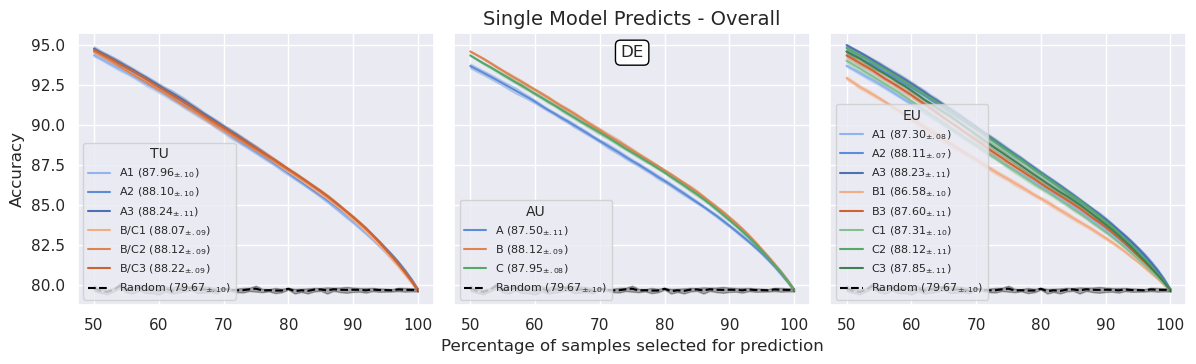

In [98]:
preds = [torch.argmax(p[:, :, 0], dim=-1) for p in probits]

data = evaluate_all(preds, y_tests, uncertainties, metric, runs)

print(data.shape)

plt_data = data.mean(dim=0)

plot(plt_data, "Single Model Predicts - Overall", f"selpred_{method}_{model}_{metric.__name__}_single_overall")

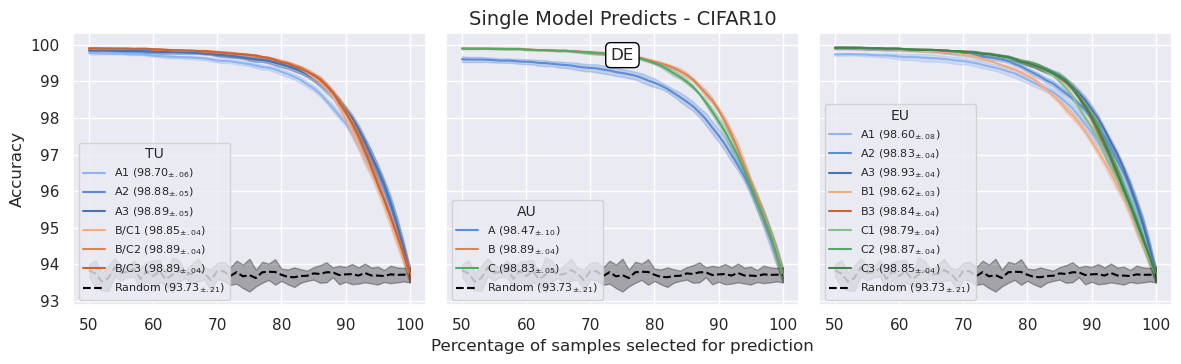

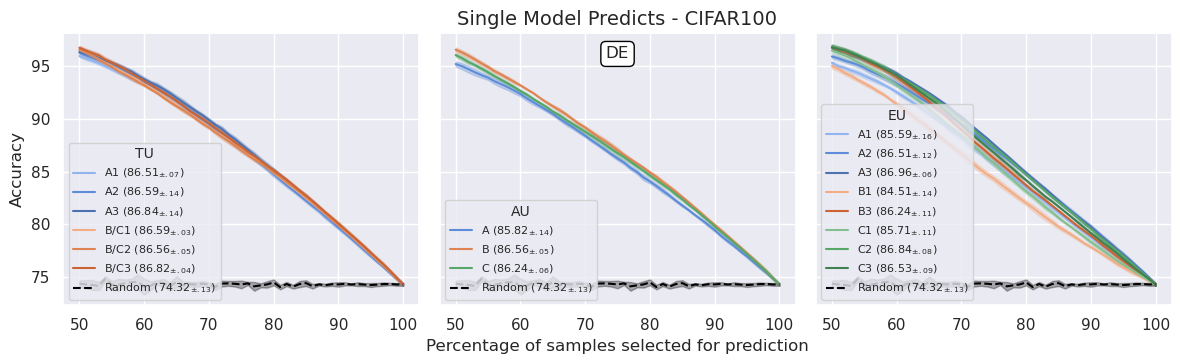

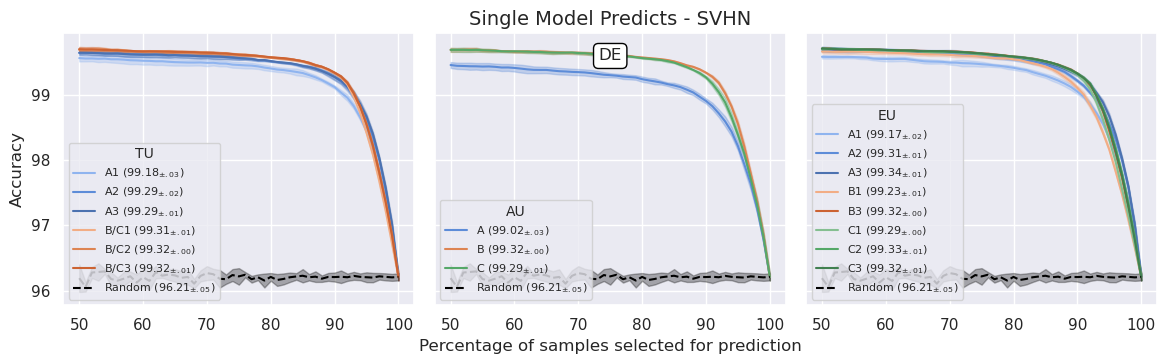

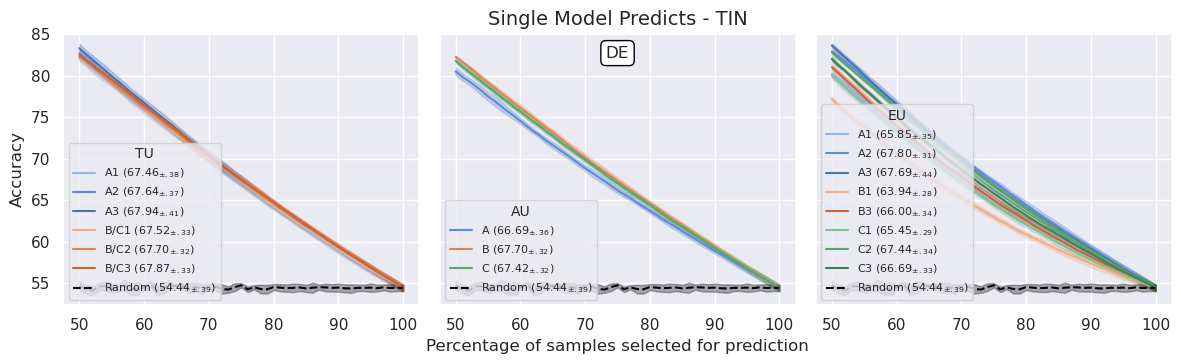

In [99]:
for i in range(len(dataset_names)):
    plot(data[i], f"Single Model Predicts - {dataset_names[i].upper()}")

## Average Model

torch.Size([4, 27, 5, 51])


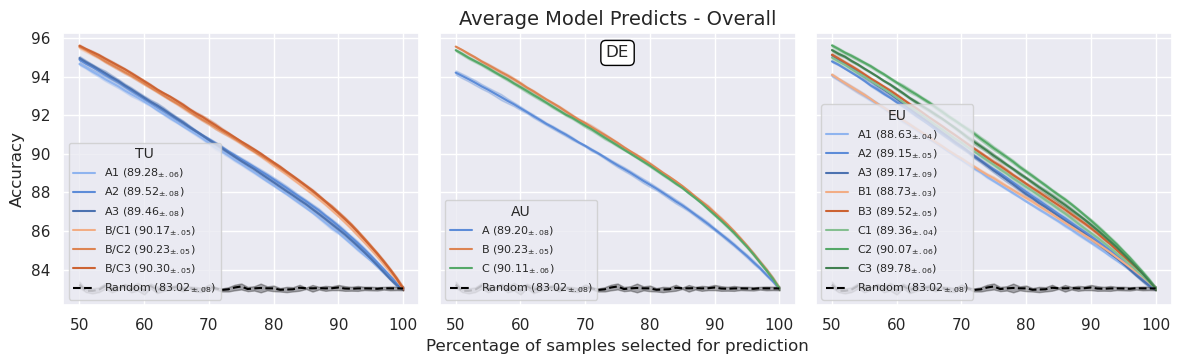

In [100]:
preds = [torch.argmax(torch.mean(p, dim=2), dim=-1) for p in probits]

data = evaluate_all(preds, y_tests, uncertainties, metric, runs)

print(data.shape)

plt_data = data.mean(dim=0)

plot(plt_data, "Average Model Predicts - Overall", f"selpred_{method}_{model}_{metric.__name__}_average_overall")

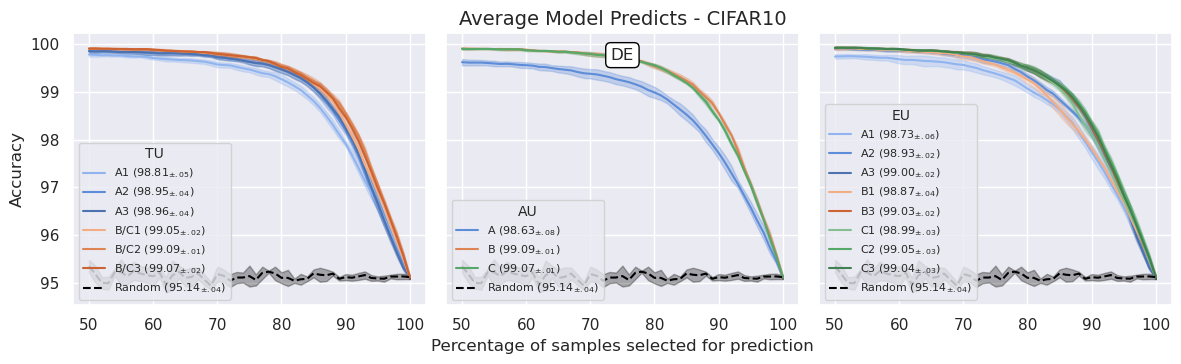

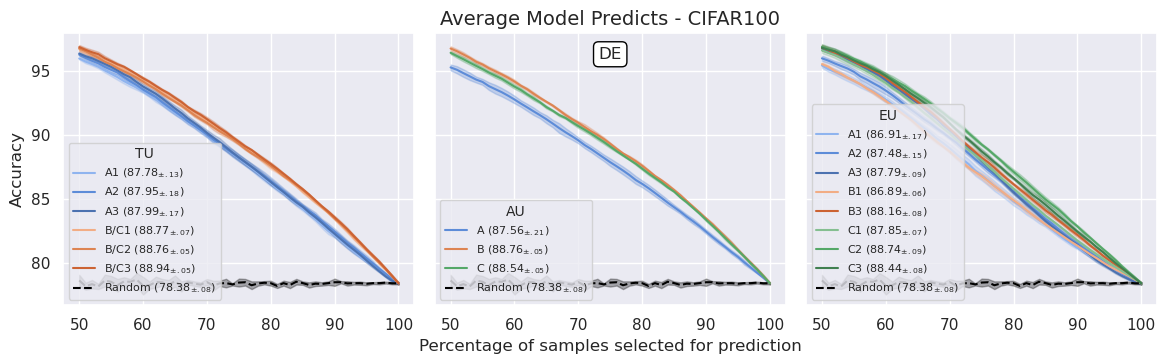

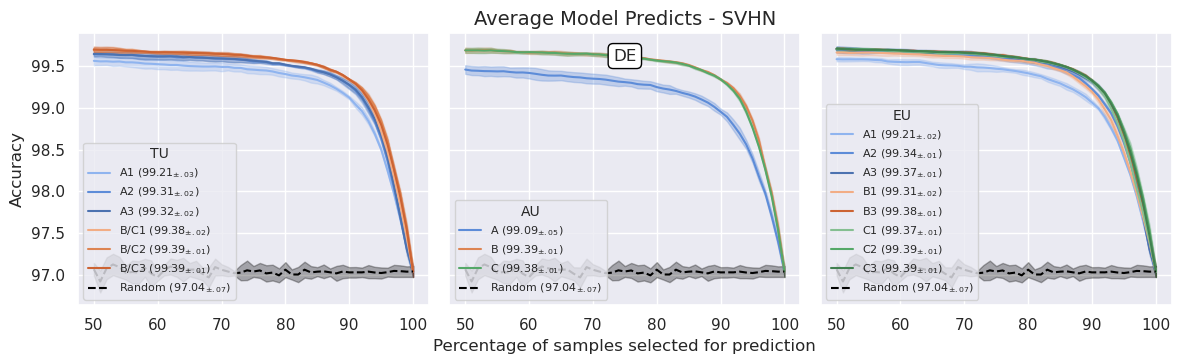

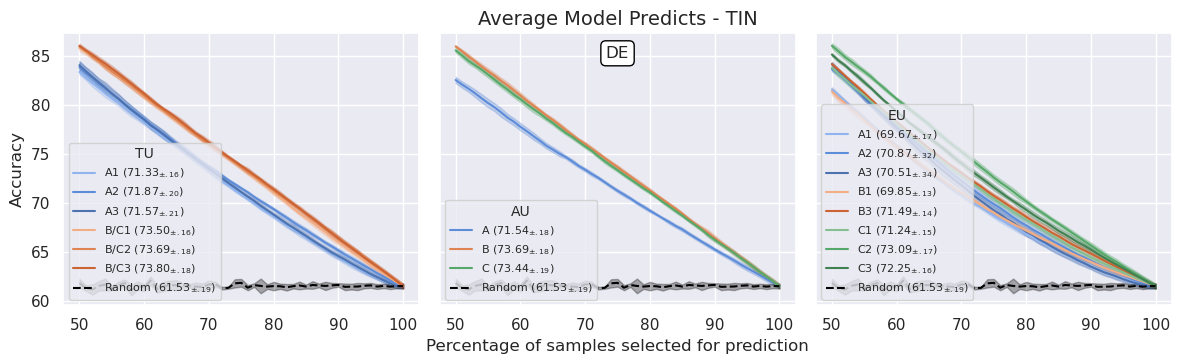

In [101]:
for i in range(len(dataset_names)):
    plot(data[i], f"Average Model Predicts - {dataset_names[i].upper()}")

torch.Size([4, 27, 5, 51])


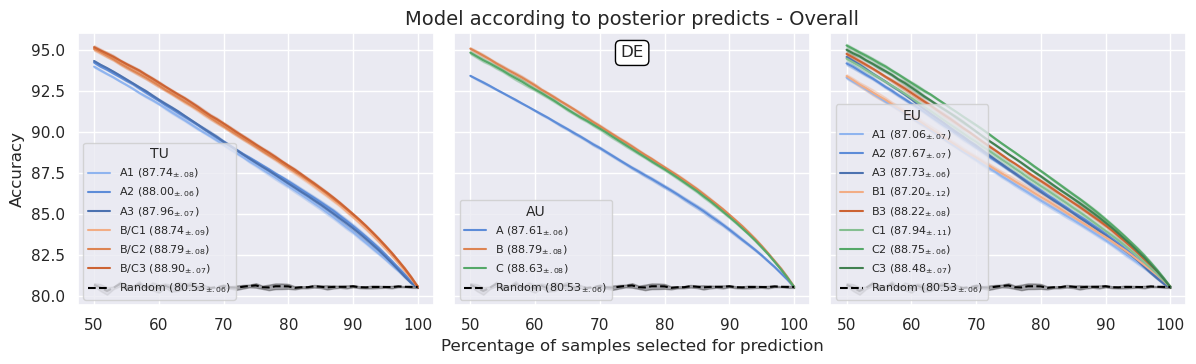

In [102]:
indices = []
for p in probits:
    indices.append(torch.randint(0, p.shape[2], (p.shape[0], p.shape[1], 1, p.shape[3])))

preds = [torch.argmax(torch.gather(p, dim=2, index=indices[i]).squeeze(2), dim=-1) for i, p in enumerate(probits)]

data = evaluate_all(preds, y_tests, uncertainties, metric, runs)

print(data.shape)

plt_data = data.mean(dim=0)

plot(plt_data, "Model according to posterior predicts - Overall", f"selpred_{method}_{model}_{metric.__name__}_posterior_overall")

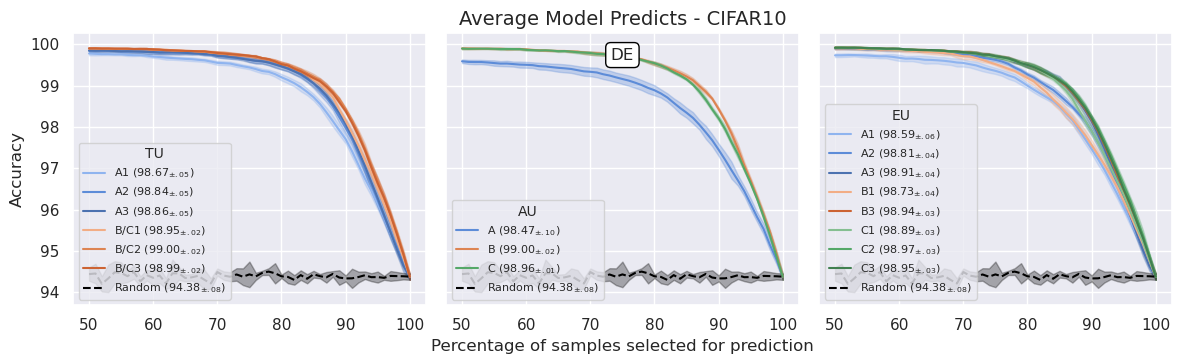

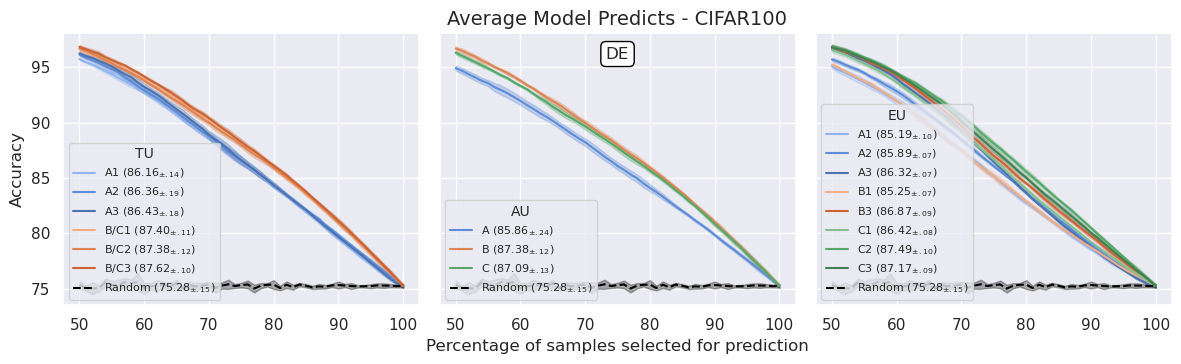

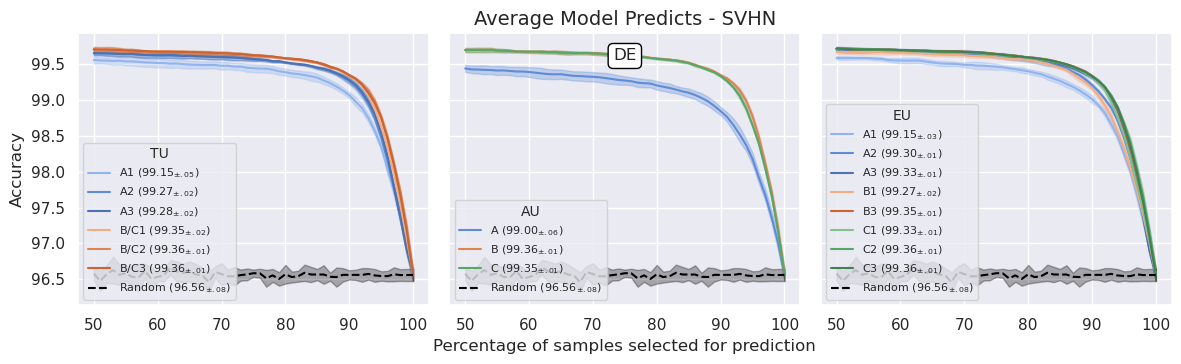

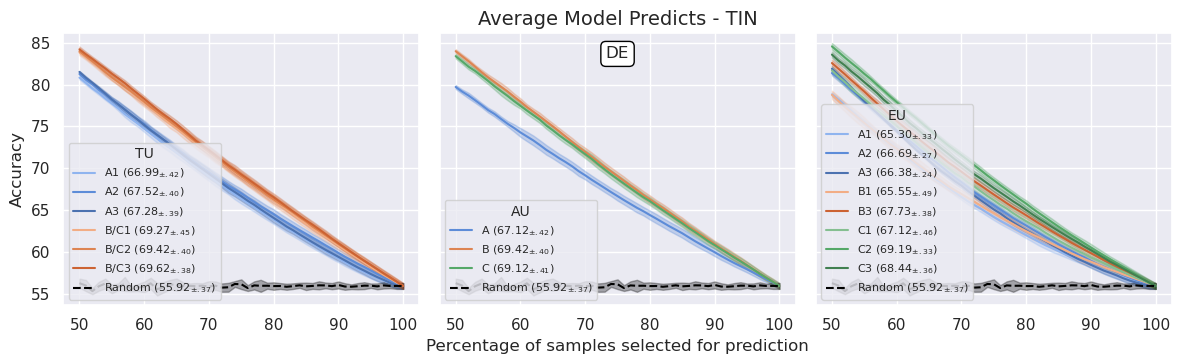

In [103]:
for i in range(len(dataset_names)):
    plot(data[i], f"Average Model Predicts - {dataset_names[i].upper()}")